# Global background esimtation

`opticam_new` uses `photutils` to handle two-dimensional image backgrounds. In this notebook, I will demonstrate how to define backgrounds for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no background is specified.

## Test Image

First thing's first, let's create and open an image so we can compute its background:

In [1]:
import opticam_new

opticam_new.generate_observations(
    out_dir='background_tutorial/data',
    n_images=20,
    )

[OPTICAM] variable source is at (122, 104)


Generating observations: 100%|██████████|[00:00<00:00]


In [2]:
from astropy.io import fits
import numpy as np
import os

files = os.listdir('background_tutorial/data')

with fits.open(f"background_tutorial/data/{files[0]}") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
FILTER  = 'i       '                                                            
BINNING = '4x4     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:12'                                                 


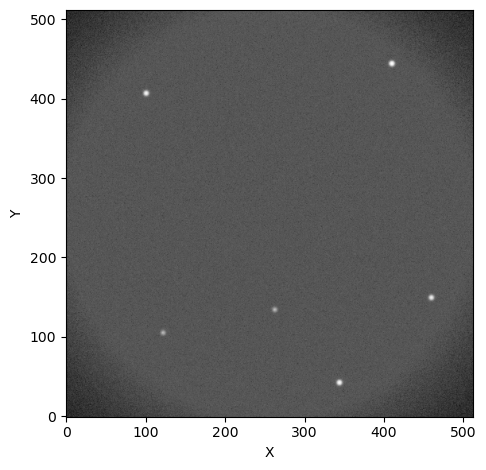

In [3]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Background

`opticam_new`'s default background estimator is the default `Background2D()` estimator from `photutils` with some added convenience tailored to OPTICAM. Let's look at the background image produced by the default estimator:

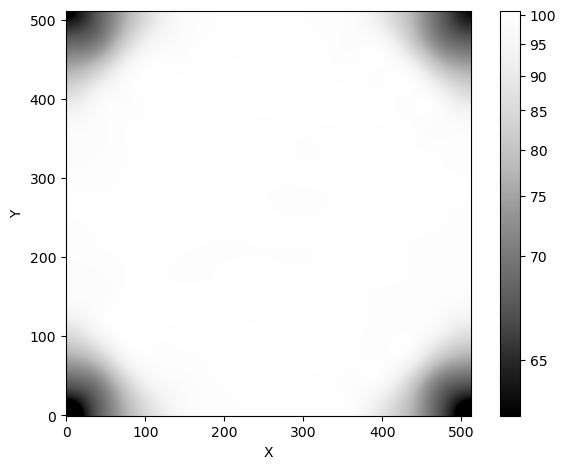

In [4]:
default_background = opticam_new.DefaultBackground(box_size=image.shape[0] // 16)

bkg = default_background(image)  # compute the background
bkg_image = bkg.background  # get the background image

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")

fig.colorbar(im)

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

Unsurprisingly, there is a lot of background in the middle of the image, with less in the corners (due to the aperture shadow). We can also look at the background mesh to see if any regions of the image have been excluded by the background estimator:

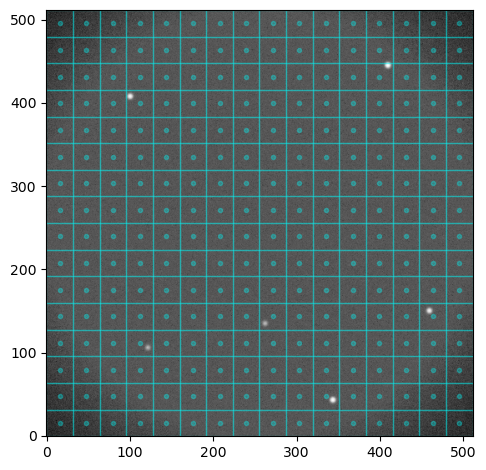

In [5]:
fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.3, ax=ax)

plt.show()

The default size of the background "pixels" for `opticam_new.DefaultBackground` is the width of the image divided by 16. This value is generally good across a range of observing conditions, but it can, of course, be changed on a case-by-case basis. The `photutils` documentation suggests setting the `box_size` (i.e., background "pixel" size) to a value which is small, but larger than the typical source size. For these simulated data, we could probably get away with a smaller `box_size`, but such fine-tunings are left to the user.

Let's subtract the background and compare the histograms of pixel values before and after removing the background from the image:

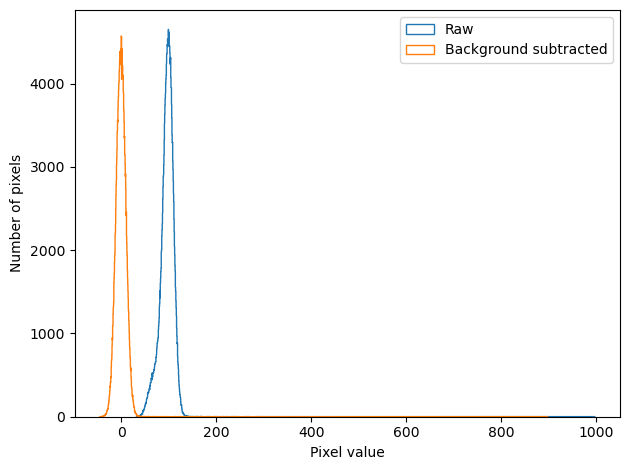

In [6]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(image.flatten(), bins='auto', histtype="step", label="Raw")
ax.hist((image - bkg_image).flatten(), bins='auto', histtype="step", label="Background subtracted")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

plt.show()

We can see that the background has been massively reduced. After subtracting the background, the pixel values appear approximately Gaussian distributed about zero.

Using `opticam_new`'s default background is extremely easy. However, in some cases, we may see better results if we implement a custom background estimator.

## Custom Backgrounds

Let's now define a custom background estimator. Custom background estimators can be any `Background2D` instance from `photutils.background`:

In [7]:
from photutils.background import Background2D, BiweightLocationBackground, BiweightScaleBackgroundRMS

class CustomBackground:
    
    def __init__(self, box_size):
        self.box_size = box_size
    
    def __call__(self, image):
        
        return Background2D(
            image,
            self.box_size,
            bkg_estimator=BiweightLocationBackground(),
            bkgrms_estimator=BiweightScaleBackgroundRMS(),
            )

In this example, I have defined `CustomBackground` to take a `box_size` parameter, just like `opticam_new.DefaultBackground`. However, `CustomBackground` uses the `photutils` `BiweightLocationBackground` background estimator and `BiweightScaleBackgroundRMS` background RMS estimator, while `opticam_new.DefaultBackground` uses the default `SExtractorBackground` and `StdBackgroundRMS` estimators. Of course, custom background and background RMS estimators can also be defined, though this is more advanced (see https://photutils.readthedocs.io/en/stable/user_guide/background.html#d-background-and-noise-estimation for more details).

When an instance of `CustomBackground` is called, it takes an `image` parameter, which is assumed to be an `NDArray`, and returns a `photutils.background.Background2D` instance. Custom `opticam_new` backgrounds **must** implement a `__call__()` method that takes an `NDArray` image input and returns a `photutils.background.Background2D` instance.

Let's now compare `CustomBackground` to `opticam_new.DefaultBackground`:

In [8]:
custom_background = CustomBackground(box_size=image.shape[0] // 16)

custom_bkg_image = custom_background(image).background

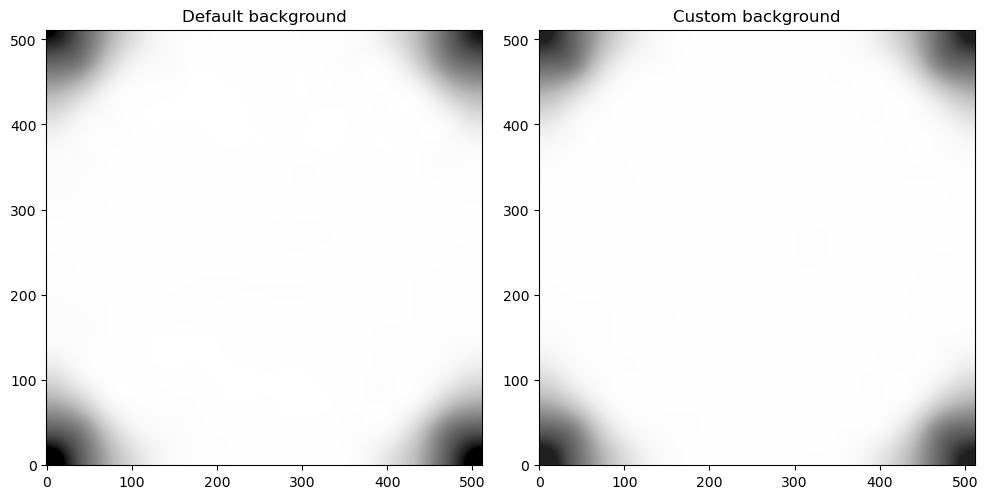

In [9]:
fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

im = ax[0].imshow(bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[0].set_title("Default background")

im = ax[1].imshow(custom_bkg_image, norm=simple_norm(bkg_image, stretch="sqrt"), origin="lower", cmap="Greys_r")
ax[1].set_title("Custom background")

plt.show()

As we can see, the two backgrounds look very similar (note that they also share the same normalisation). Let's compare the histograms between these two background estimators:

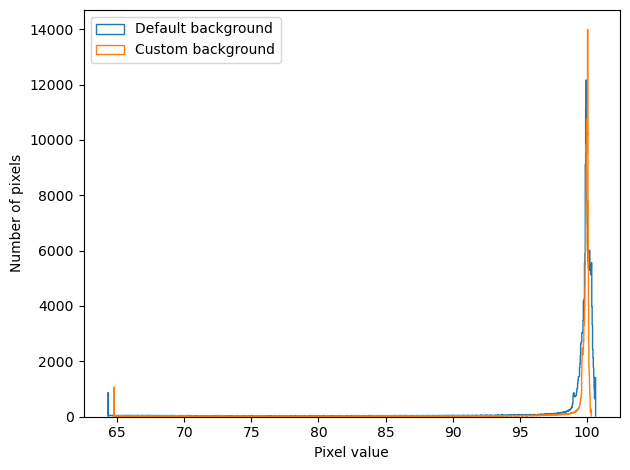

In [10]:
fig, ax = plt.subplots(tight_layout=True)

ax.hist(bkg_image.flatten(), bins='auto', histtype="step", label="Default background")
ax.hist(custom_bkg_image.flatten(), bins='auto', histtype="step", label="Custom background")

ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of pixels")

ax.legend()

plt.show()

Now we can see that the two estimators are more different that they previously looked.

Let's see how to pass our custom background estimator to `opticam_new.Catalog`. We'll also apply flat-field corrections as in the [Applying Corrections Tutorial](applying_corrections.ipynb), which means we'll first need to generate some flats:

In [11]:
opticam_new.generate_flats(
    out_dir='background_tutorial/flats'
)

Generating flats: 100%|██████████|[00:00<00:00]


Now let's define our corrector and a `Catalog` instance:

[OPTICAM] 5 i-band flat-field images.
[OPTICAM] 5 g-band flat-field images.
[OPTICAM] 5 r-band flat-field images.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]

[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


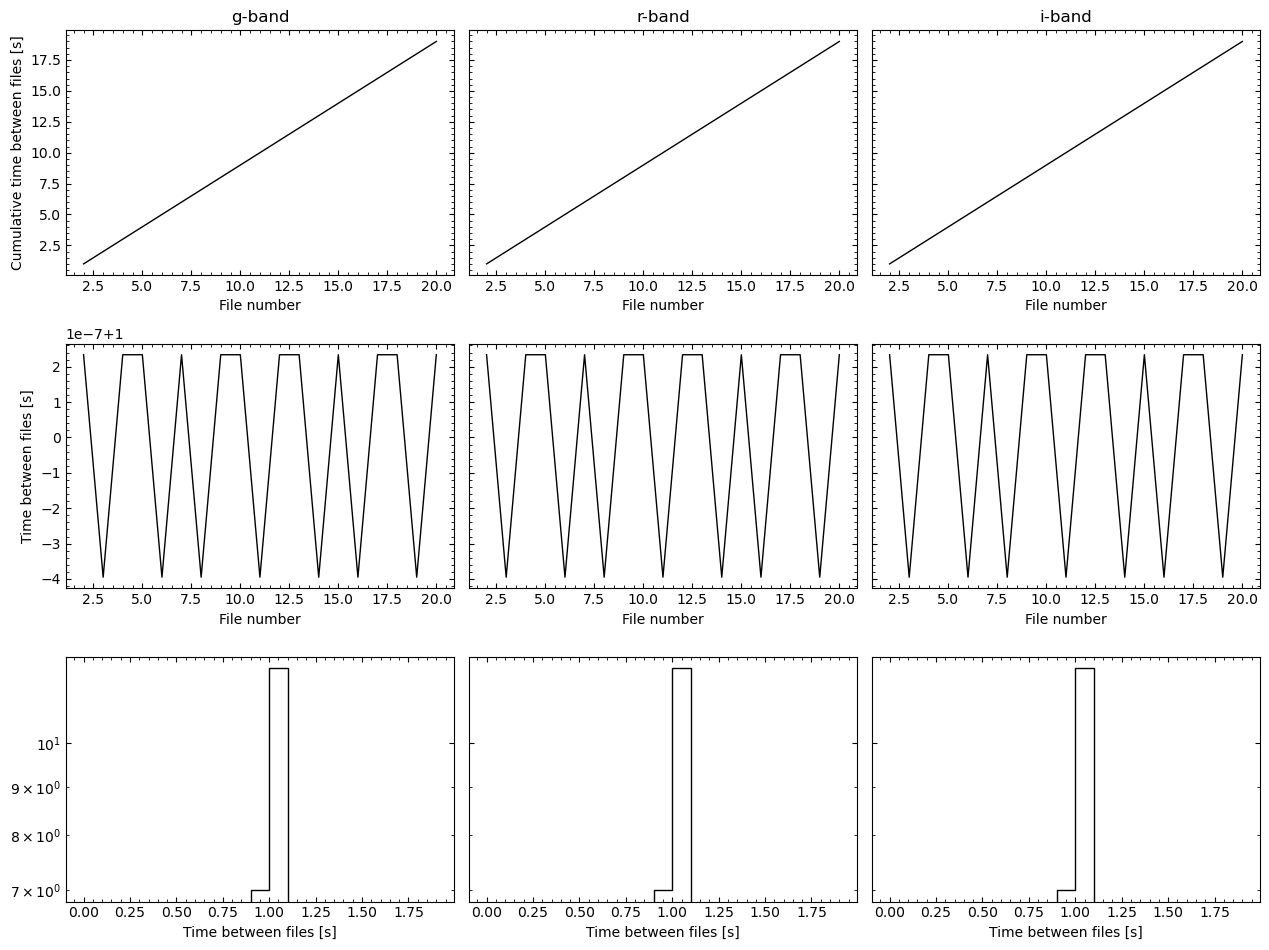

In [12]:
flat_corr = opticam_new.FlatFieldCorrector(
    out_dir='background_tutorial/master_flats',
    flats_dir='background_tutorial/flats'
)

cat = opticam_new.Catalog(
    out_directory='background_tutorial/results',
    data_directory='background_tutorial/data',
    remove_cosmic_rays=False,
    flat_corrector=flat_corr,
    background=custom_background,
)

[OPTICAM] Initialising catalogs
[OPTICAM] g-band master flat-field image not found. Attempting to create...
[OPTICAM] Master flat-field image created.


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


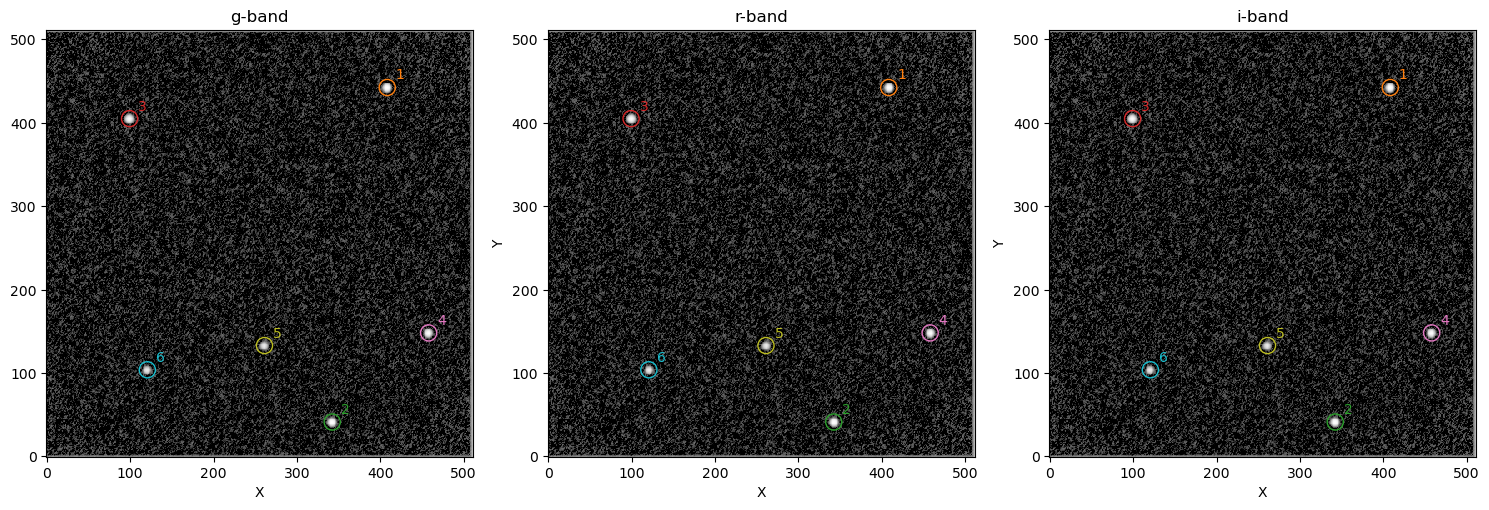

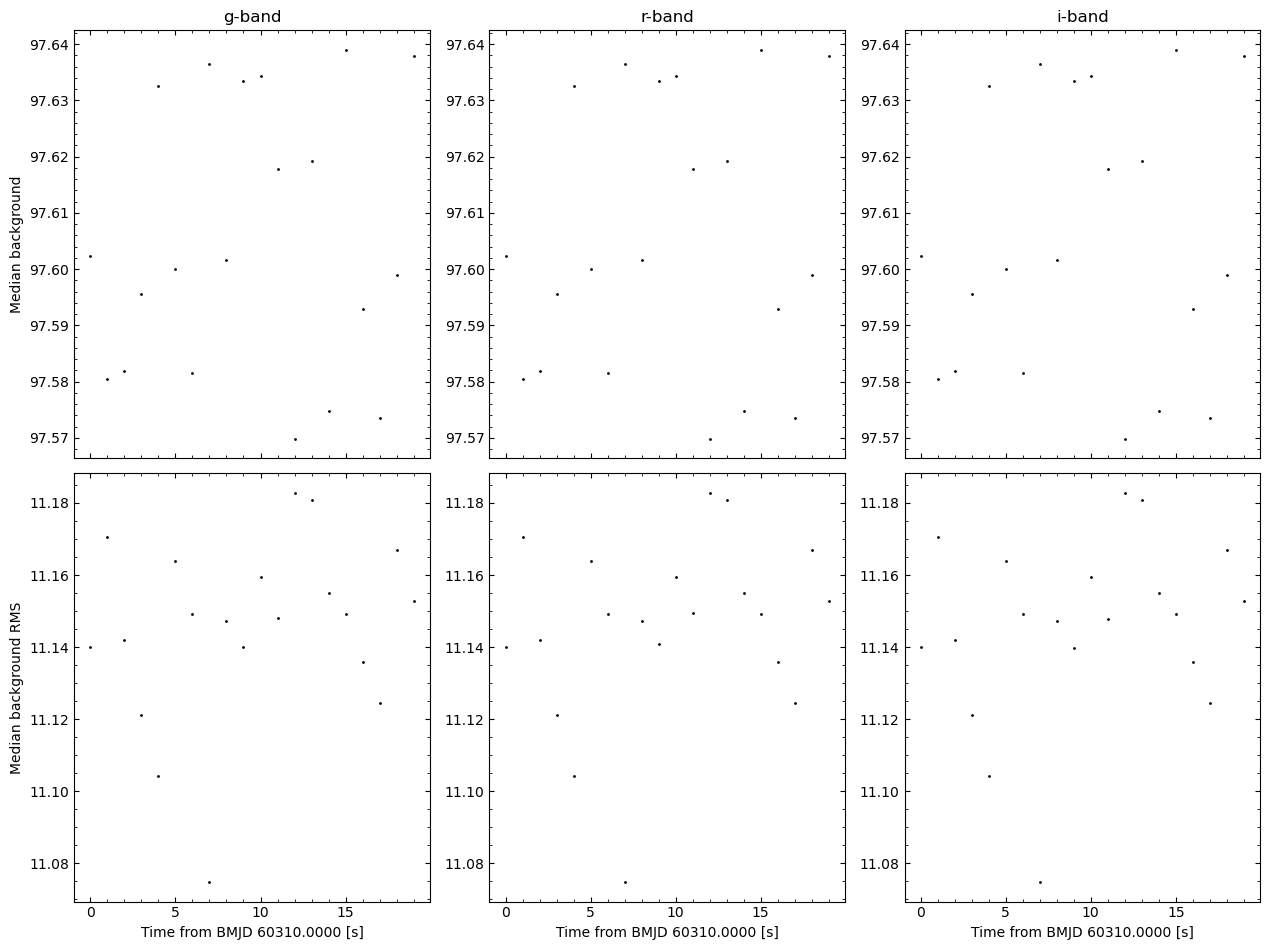

In [13]:
cat.create_catalogs(show_diagnostic_plots=True)

As we can see, our custom background estimator infers an average background of ~97.6 counts. The expected value is 100 counts, so our background estimator is pretty close! 

That concludes the backgrounds tutorial for `opticam_new`! In most cases, `opticam_new.DefaultBackground` should be "good enough", but we have seen how custom background estimators could be implemented if necessary. For more details on implementing custom background estimators, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/user_guide/background.html#d-background-and-noise-estimation.